

---


# **Libraries and dataset loading**


---



In [1]:
!pip install tensorflow-addons
!pip install pydub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.9 MB/s eta 0:00:00


In [2]:
import os
import zipfile
import pandas as pd
from google.colab import files
from PIL import Image
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from google.colab import drive
import io
import librosa
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from pathlib import Path
from PIL import Image as PILImage
import tensorflow_addons as tfa
from IPython.display import Audio
from pydub import AudioSegment
from ipywidgets import FileUpload

drive.mount('/content/drive')


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/drive


In [ ]:
# Setup Kaggle
kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
kaggle_json_path = os.path.join(kaggle_dir, 'kaggle.json')
os.makedirs(kaggle_dir, exist_ok=True)

# Upload Kaggle JSON
if not os.path.exists(kaggle_json_path):
   print("Upload your kaggle.json file.")
   files.upload()
   os.system('cp kaggle.json ~/.kaggle/')
   os.system('chmod 600 ~/.kaggle/kaggle.json')

# Download and Extract Dataset
zip_file_path = '100-bird-species.zip'
if not os.path.exists(zip_file_path):
   os.system('kaggle datasets download -d gpiosenka/100-bird-species')
   with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall()

Upload your kaggle.json file.


In [ ]:
# Load and Preprocess Data
birds_csv_path = 'birds.csv'
if os.path.exists(birds_csv_path):
   birds_df = pd.read_csv(birds_csv_path)
   birds_df['filepaths'] = birds_df['filepaths'].str.replace('AKULET', 'AUKLET', regex=False)
   birds_df['filepaths'] = birds_df['filepaths'].str.replace('valid/PARAKETT  AUKLET/5.jpg', 'valid/PARAKETT AUKLET/5.jpg', regex=False)
   birds_df['filepaths'] = birds_df['filepaths'].str.replace('valid/PARAKETT  AUKLET/4.jpg', 'valid/PARAKETT AUKLET/4.jpg', regex=False)
   birds_df['filepaths'] = birds_df['filepaths'].str.replace('valid/PARAKETT  AUKLET/3.jpg', 'valid/PARAKETT AUKLET/3.jpg', regex=False)
   birds_df['filepaths'] = birds_df['filepaths'].str.replace('valid/PARAKETT  AUKLET/2.jpg', 'valid/PARAKETT AUKLET/2.jpg', regex=False)
   birds_df['filepaths'] = birds_df['filepaths'].str.replace('valid/PARAKETT  AUKLET/1.jpg', 'valid/PARAKETT AUKLET/1.jpg', regex=False)
   birds_df['labels'] = birds_df['labels'].str.replace('AKULET', 'AUKLET', regex=False)
else:
   print("Dataset not found.")

Loading the right ordered labels for the classification

In [ ]:
######################### TEST #########################
test_path = '/content/test'

test_dir = Path(test_path)

filepaths = list(test_dir.glob(r'**/*.JPG')) + list(test_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.png')) + list(test_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='filepaths', dtype=str)
labels = pd.Series(labels, name='labels', dtype=str)

label_df = pd.concat([filepaths, labels], axis=1)
label_datagen = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input)

label_generator = label_datagen.flow_from_dataframe(label_df
                                                  ,x_col='filepaths'
                                                  ,y_col='labels'
                                                  ,target_size = (150, 150)
                                                  ,batch_size = 20
                                                  ,shuffle = False
                                                       )



---


# **Functions**


---


In [ ]:
#FUNZIONI DELLA DEMO

def find_file_in_drive(filename):
    for root, dirs, files in os.walk('/content/drive'):
        if filename in files:
            return os.path.join(root, filename)

    # Se il file non viene trovato, mostra il widget per il caricamento del file
    print(f"File '{filename}' non trovato. Carica il file:")
    upload_widget = FileUpload(accept='', multiple=False)
    display(upload_widget)

    def handle_upload(change):
        uploaded_file = list(upload_widget.value.values())[0]
        with open(filename, 'wb') as f:
            f.write(uploaded_file['content'])
        print(f"File '{filename}' caricato con successo.")
        upload_widget.close()

    upload_widget.observe(handle_upload, names='data')
    return None

def is_valid_label(label, dataframe):
      return label.upper() in dataframe['labels'].str.upper().unique()


#CLASSIFICATION IMMAGINI


def on_upload_change_image(change):
     global global_image_path_jpg
     if change['new']:
         # Prendi l'ultimo file caricato
         uploaded_file =  list(upload_button.value.values())[-1]
         content = uploaded_file['content']
         image_path = uploaded_file['metadata']['name']
         global_image_path_jpg = image_path.split('.')[0] + '.jpg'

         with open(global_image_path_jpg, 'wb') as f:
            f.write(content)

         image = PILImage.open(io.BytesIO(content)).convert('RGB')
         image = image.resize((150, 150))

         with image_display:
              clear_output(wait=True)
              display(image)

def on_validate_button_clicked(b):
      with output:
           clear_output(wait=True)
           print("Loading...")
           label = species_dropdown.value
           if is_valid_label(label, birds_df) and global_image_path_jpg:
              #Loading the model
              filename = 'IV3TRF.keras'
              file_path = find_file_in_drive(filename)

              if file_path is not None:
                  model = keras.models.load_model(file_path)
                  print("Model Uploaded:", file_path)
              else:
                  print("File not found")
              try_df = pd.DataFrame({'filepaths': [global_image_path_jpg], 'labels': [label]})
              print(f"Selected bird species: {label}")
              try_datagen = ImageDataGenerator(preprocessing_function=keras.applications.inception_v3.preprocess_input)
              try_generator = try_datagen.flow_from_dataframe(try_df
                                                              ,x_col='filepaths'
                                                              ,y_col='labels'
                                                              ,target_size = (150, 150)
                                                              ,shuffle = False
                                                              )

              # use the model to predict the image:
              pred = model.predict(try_generator)
              pred = np.argmax(pred, axis = 1)

              # Map the label
              labels = (label_generator.class_indices)
              labels = dict((v,k) for k,v in labels.items())
              pred = [labels[k] for k in pred]

              #retrieve the ground truth species labels
              y_try = list(try_df.labels)

              bimage = plt.imread(global_image_path_jpg)

              if pred == y_try:
                color = 'green'
              else:
                color = 'red'

              # Creazione del plot
              fig = Figure()
              ax = fig.subplots()
              ax.set_title(f"True: {y_try[0]}\nPredicted: {pred[0]}", color=color)
              ax.axis('off')
              img = PILImage.open(global_image_path_jpg)
              ax.imshow(img)

              # Salvataggio del plot in un buffer
              canvas = FigureCanvas(fig)
              buf = io.BytesIO()
              canvas.print_png(buf)
              buf.seek(0)
              with output:
                   img = PILImage.open(buf)
                   display(img)

              buf.close()
           else:
              print("Bird species not found or image not uploaded. Please re-enter a bird species and upload an image")


#CLASSIFICATION AUDIO

def on_bird_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
       print("Uccello Selezionato:", change['new'])


def get_spectrograms(filepath, output_dir):
    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE, offset=None, duration=15)
    sig_splits = []
    for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
        split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]
        if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
            break
        sig_splits.append(split)

    s_cnt = 0
    saved_samples = []
    for chunk in sig_splits:
        hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y=chunk, sr=SAMPLE_RATE, n_fft=1024, hop_length=hop_length, n_mels=SPEC_SHAPE[0], fmin=FMIN, fmax=FMAX)
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()

        save_path = os.path.join(output_dir, f'spectrogram_{s_cnt}.png')
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(save_path)
        saved_samples.append(save_path)
        s_cnt += 1

    return saved_samples


from pydub import AudioSegment

def on_upload_change_audio(change):
    if change['new']:
        uploaded_file = list(upload_button.value.values())[-1]
        content = uploaded_file['content']
        original_filepath = 'temp_audio_file_original'
        ogg_filepath = 'temp_audio_file.ogg'

        # Salvare il file originale
        with open(original_filepath, 'wb') as f:
            f.write(content)

        # Determinare il formato del file caricato e convertirlo in .ogg
        format = uploaded_file['metadata']['name'].split('.')[-1]
        if format.lower() == 'mp3':
            audio = AudioSegment.from_mp3(original_filepath)
        elif format.lower() == 'wav':
            audio = AudioSegment.from_wav(original_filepath)
        elif format.lower() == 'flac':
            audio = AudioSegment.from_file(original_filepath, 'flac')
        else:
            # Assumiamo che il formato sia già .ogg
            audio = AudioSegment.from_ogg(original_filepath)

        # Esportare in formato .ogg
        audio.export(ogg_filepath, format='ogg')

        # Visualizzare l'audio (puoi scegliere di visualizzare l'originale o il .ogg)
        display(Audio(ogg_filepath))

        if not os.path.exists('temp_spectrograms'):
            os.makedirs('temp_spectrograms')

        # Utilizzare il file .ogg per generare gli spettrogrammi
        spectrogram_paths = get_spectrograms(ogg_filepath, 'temp_spectrograms')


def classify_spectrograms(spectrogram_paths, model):
    if not model:
        modelname = 'modello.h5'
        modelpath = find_file_in_drive(modelname)
        model = tf.keras.models.load_model(modelpath)

    last_prediction_label = None
    for spec_path in spectrogram_paths:
        img = Image.open(spec_path).resize((128, 48))
        img_array = np.array(img).reshape((1, 48, 128, 1))
        img_array = img_array / 255.0

        prediction = model.predict(img_array, verbose=0)
        predicted_class_index = np.argmax(prediction, axis=1)
        predicted_class_label = class_labels[predicted_class_index[0]]
        last_prediction_label = predicted_class_label  # Memorizza l'ultima label predetta
        user_selected_label = bird_selection.value  # Ottieni la label selezionata dall'utente

    if last_prediction_label is not None:
        print("Uccello Predetto dal Modello:", predicted_class_label)

def on_classify_button_clicked(b):
    with loading_output:
        clear_output(wait=True)
        print("Loading...")

    with output_classify:
        clear_output(wait=True)
        spectrogram_paths = get_spectrograms('temp_audio_file.ogg', 'temp_spectrograms')
        classify_spectrograms(spectrogram_paths, None)

    with loading_output:
        clear_output(wait=True)

#RETRIVAL

def extract_features_single_image(image_path, model):
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize((299, 299))
        image_array = np.array(image)
        image_array = preprocess_input(image_array)
        image_array = np.expand_dims(image_array, axis=0)
        features = model.predict(image_array)
        return features.reshape(1, -1)
    except IOError:
        print(f"Errore nel caricare l'immagine da {image_path}")
        return None



def find_similar_images_cosine(query_idx, features, top_n=5):
    query_feature = features[query_idx].reshape(1, -1)
    similarity_scores = cosine_similarity(query_feature, features)[0]
    similarity_scores[query_idx] = -1  # Exclude the query image from the results

    top_indices = np.argsort(similarity_scores)[::-1][:top_n]
    return top_indices, similarity_scores[top_indices]



def display_similar_images(indices, scores, labels, image_paths, query_img, query_idx, query_label, rows=2, cols=3):

    # Adjust the layout
    total_images = len(indices) + 1  # +1 for the query image
    cols = min(cols, total_images)
    rows = max(1, (total_images + cols - 1) // cols)  # Ceiling division for rows

    plt.figure(figsize=(cols * 4, rows * 4))

    # Display the query image with its label
    plt.subplot(rows, cols, 1)
    plt.imshow(query_img)
    plt.title(f"Query: {query_label}")
    plt.axis('off')

    # Display similar images with their labels and similarity scores
    for i, (index, score, label) in enumerate(zip(indices, scores, labels), start=2):
        try:
            similar_image = plt.imread(image_paths[index])
            plt.subplot(rows, cols, i)
            plt.imshow(similar_image)
            similarity_percentage = score * 100  # Convert score to percentage
            plt.title(f"{birds_df.iloc[index].labels}\nSimilarity: {similarity_percentage:.2f}%")
            plt.axis('off')
        except IOError:
            print(f"Error loading image at index {index}")

    plt.tight_layout()
    plt.show()


def get_img_array(img_path, size):
    img = keras_image.load_img(img_path, target_size=size)
    array = keras_image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
                                      )
    with tf.GradientTape() as tape:
         last_conv_layer_output, preds = grad_model(img_array)
         if pred_index is None:
            pred_index = tf.argmax(preds[0])
         class_channel = preds[:, pred_index]

         grads = tape.gradient(class_channel, last_conv_layer_output)
         pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
         last_conv_layer_output = last_conv_layer_output[0]
         heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
         heatmap = tf.squeeze(heatmap)
         heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
         return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, alpha=0.9):
    # Load the original image
    img = keras_image.load_img(img_path)
    img = keras_image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    heatmap[heatmap < 150] = 0  # Adjust this threshold as needed

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras_image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras_image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras_image.array_to_img(superimposed_img)
    return keras_image.array_to_img(superimposed_img)

---


# **Task1 demo birds Audio classification**


The demo birds retrival can be runned through the following steps:

  

1. Loading the file audio, and selecting the correct label, for example: **pilwoo**
2. Running inference to see the model's prediction of which bird the loaded call matches


  

---

In [ ]:
SAMPLE_RATE = 22050
SIGNAL_LENGTH = 5
SPEC_SHAPE = (128, 128)
FMIN = 500
FMAX = 12500

# Global vars
RANDOM_SEED = 1337
SAMPLE_RATE = 32000
SIGNAL_LENGTH = 5 # seconds
SPEC_SHAPE = (48, 128) # height x width
FMIN = 500
FMAX = 12500


style = {'description_width': 'initial'}
layout = {'width': '50%', 'margin': '10px 0'}

loading_output = widgets.Output()

file_name = 'LABELS.pkl'
filepath = find_file_in_drive(file_name)
with open(filepath, 'rb') as f:
    class_labels = pickle.load(f)

bird_selection = widgets.Dropdown(
    options=class_labels,
    description='Scegli specie inserita:',
    disabled=False,
    style=style,
    layout=layout
)

upload_button = widgets.FileUpload(accept='audio/*', multiple=False, style=style, layout=layout)
output = widgets.Output()

upload_button.observe(on_upload_change_audio, names='data')

classify_button = widgets.Button(description="Classify", style=style, layout=layout)
output_classify = widgets.Output()


classify_button.on_click(on_classify_button_clicked)

display(upload_button, bird_selection, output, classify_button, loading_output, output_classify)
bird_selection.observe(on_bird_change)



FileUpload(value={}, accept='audio/*', description='Upload', layout=Layout(margin='10px 0', width='50%'))

Dropdown(description='Scegli specie inserita:', layout=Layout(margin='10px 0', width='50%'), options=('banswa'…

Output()

Button(description='Classify', layout=Layout(margin='10px 0', width='50%'), style=ButtonStyle())

Output()

Output()

Uccello Selezionato: pilwoo




---


- The audio labels are not directly the species name, this is how the dataset was built.

- To retrieve the actual species name you need to add after the `species/` slash of this link the label, for example `LABEL = goowoo1`

-  `https://ebird.org/species/INSERT_LABEL`

- Example: https://ebird.org/species/goowoo1 --> `Golden-olive Woodpecker`
      
- This information can be helpful if you want to test the model with audio of birds coming from new sources. Or also to assess the actual species name.

---




---


# **Task2 demo birds Image classification**

The demo birds classification can be runned through the following steps:

1. Loading the model.

2. Loading the image, and selecting the correct label for example: BLACK SWAN

3. Running the inference

4. Plotting the result

---



In [ ]:
output = widgets.Output()
style = {'description_width': 'initial'}
layout = {'width': '50%', 'margin': '10px 0'}


# Widget per il caricamento dell'immagine
upload_button = widgets.FileUpload(accept='image/*', multiple=False, description="Upload Image", style=style, layout=layout)
image_display = widgets.Output()

upload_button.observe(on_upload_change_image, names='data')

# Dropdown menu per selezionare la specie di uccello
species_dropdown = widgets.Dropdown(
        options=birds_df['labels'].unique().tolist(),
        description='Bird Species:',
        disabled=False,
        style=style, layout=layout)

validate_button = widgets.Button(description='Validate and Process',style=style, layout=layout)
validate_button.on_click(on_validate_button_clicked)

# Contenitore per organizzare i widget
container = widgets.VBox([upload_button, image_display, species_dropdown, validate_button, output],
                         layout=widgets.Layout(
                               display='flex',
                               flex_flow='column',
                               width='100%'
                               ))

# Mostra i widget
display(upload_button,image_display,species_dropdown,validate_button,output)

---


# **Task3 demo birds retrieval**

The demo birds retrival can be runned through the following steps:

1. Loading the image, and selecting the correct label for example: BLACK SWAN

2. Running the inference to display the 5 most similar images

3. Running the inference to display the GRAD-CAM

---



In [ ]:
style = {'description_width': 'initial'}
layout = {'width': '50%', 'margin': '10px 0'}

output = widgets.Output()

# Funzione per caricare l'immagine
def upload_image(change):
  with output:
    global image_path, image
    uploaded_file = list(change['new'].values())[0]
    image_path = 'uploaded_image.jpg'
    with open(image_path, 'wb') as f:
         f.write(uploaded_file['content'])
    image = Image.open(image_path).convert('RGB')
    image = image.resize((299, 299))
    image_path = image_path.split('.')[0] + '.jpg'
    display(image)

# Widget per il caricamento dell'immagine
upload_button = widgets.FileUpload(accept='image/*', multiple=False, style=style, layout=layout)
upload_button.observe(upload_image, names='value')


# Dropdown menu per selezionare la specie di uccello
species_dropdown = widgets.Dropdown(
      options=birds_df['labels'].unique().tolist(),
      description='Bird Species:',
      disabled=False,
      style=style,
      layout=layout
      )


def find_similar(b):
      with output:
           global similar_indices
           clear_output(wait=True)
           print("Loading...")
           if image_path:  # Assicurati che l'immagine sia stata caricata
              label = species_dropdown.value
              # Carica e prepara il modello, se non è già stato fatto
              base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3), pooling='max')
              model = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)
              # Carica la lista delle caratteristiche se necessario
              filename = 'feature_list.pkl'
              file_path = find_file_in_drive(filename)
              if file_path:
                 with open(file_path, 'rb') as file:
                      feature_list_demo = pickle.load(file)
                 print("Feature list loaded")
              else:
                 print("Feature list file not found")
                 return
              # Elaborazione dell'immagine caricata
              uploaded_features = extract_features_single_image(image_path, model)
              if uploaded_features is not None:
                 print("Uploaded image features extracted")

                 # Trova immagini simili
                 similar_indices, similar_scores = find_similar_images_cosine(-1, np.vstack([feature_list_demo, uploaded_features]), top_n=6)

                 # Ottieni i percorsi delle immagini e le label da birds_df
                 image_paths = birds_df['filepaths'].tolist()
                 labels = birds_df['labels'].tolist()

                 # Visualizzazione dei risultati
                 display_similar_images(similar_indices[1:], similar_scores[1:], labels, image_paths, np.array(image), -1, label)
              else:
                 print("Error in image feature extraction")
           else:
              print("Upload an Image")



# Bottone per avviare la ricerca
find_button = widgets.Button(description='Find Similar Images', style=style, layout=layout)
find_button.on_click(find_similar)

# Contenitore per organizzare i widget
container = widgets.VBox([
        upload_button,
        species_dropdown,
        find_button,
        output
        ],
        layout=widgets.Layout(
        display='flex',
        flex_flow='column',
        align_items='center',
        width='100%'
        ))

# Mostra i widget
display(upload_button, species_dropdown, find_button, output)


FileUpload(value={}, accept='image/*', description='Upload', layout=Layout(margin='10px 0', width='50%'))

Dropdown(description='Bird Species:', layout=Layout(margin='10px 0', width='50%'), options=('ABBOTTS BABBLER',…

Button(description='Find Similar Images', layout=Layout(margin='10px 0', width='50%'), style=ButtonStyle())

Output()

Grad-CAM

1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 2s 2s/step


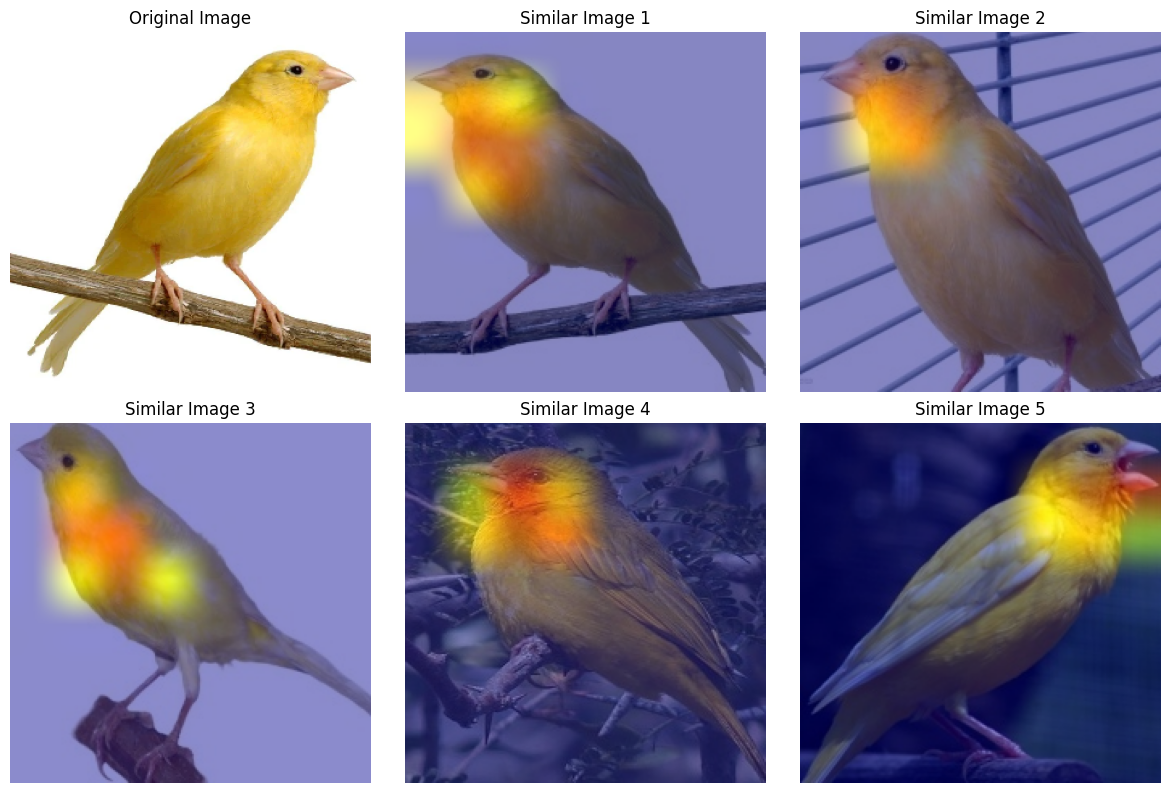

In [ ]:
img_size = (299, 299)  # Size for InceptionV3
last_conv_layer_name = 'mixed10'  # Last conv layer in InceptionV3

total_images = 1 + 5  # 1 for the original image + 5 similar images
num_rows = total_images // 3 + int(total_images % 3 > 0)

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(12, num_rows * 4))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()


# Display the original image first
original_img = keras_image.load_img(image_path, target_size=img_size)
axes_flat[0].imshow(original_img)
axes_flat[0].set_title("Original Image")
axes_flat[0].axis('off')

# Iterate over similar images and apply Grad-CAM
for i, idx in enumerate(similar_indices[1:6], start=1):
    similar_img_path = birds_df['filepaths'][idx]  # Adjust according to your dataset
    img_array = preprocess_input(get_img_array(similar_img_path, size=img_size))
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3), pooling='max')
    model = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)
    # Predict class and generate heatmap
    preds = model.predict(img_array)
    pred_class_idx = np.argmax(preds[0])
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_class_idx)

    # Superimpose heatmap on original image
    superimposed_img = save_and_display_gradcam(similar_img_path, heatmap)

    # Display the image with Grad-CAM
    axes_flat[i].imshow(superimposed_img)
    axes_flat[i].set_title(f"Similar Image {i}")
    axes_flat[i].axis('off')

for j in range(total_images, num_rows * 3):
      axes_flat[j].axis('off')

plt.tight_layout()
plt.show()